<a href="https://colab.research.google.com/github/oneoclockc/deeplearning-for-AI/blob/main/chapter10_dl-for-timeseries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep learning for timeseries

## Different kinds of timeseries tasks

시계열 데이터 -> 일정한 간격으로 측정을 통해 얻은 모든 데이터  
ex) 일일 주가, 도시의 시간당 전력 소비량, 상점의 주간 판매량 

시계열로 가능한 작업
- classification : 분류 시계열에 하나 이상의 범주형 레이블 할당. 예를 들어, 웹 사이트에서 방문자의 활동 시계열이 주어지면 방문자가 로봇인지 사람인지 판단한다.
- event detection : 데이터 스트림 내에서 예상되는 특정 이벤트의 발생 식별. 예를 들어, 모델이 오디오 스트림을 모니터링해 "오케이 구글" 등의 발화를 식별
- anomaly detection : 데이터 스트림 내의 비정상적 현상을 탐지. 예를 들어, 회사 네트워크에서 비정상적인 활동이 있는지 식별

## A temperature-forecasting example

기상 시계열 데이터 다운로드  
-> 수년에 걸쳐 10분마다 14개의 변수(온도, 기압, 습도, 풍향 등)을 측정. 2009-2016년

In [1]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2022-06-01 15:24:59--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.8.150
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.8.150|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  14.0MB/s    in 0.9s    

2022-06-01 15:25:00 (14.0 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


**Inspecting the data of the Jena weather dataset**

In [2]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read() # 파일 읽어오기

lines = data.split("\n") # 줄바꿈 기준으로 데이터 나눔 
header = lines[0].split(",") # header는 가장 윗줄 
lines = lines[1:] # 두번째 줄부터 line에 할당
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [3]:
lines

['01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.30',
 '01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.10',
 '01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.60',
 '01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.20,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.00',
 '01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.10,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.30',
 '01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.40,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.70',
 '01.01.2009 01:10:00,996.50,-7.62,265.81,-8.30,94.80,3.44,3.26,0.18,2.04,3.27,1305.68,0.18,0.63,166.50',
 '01.01.2009 01:20:00,996.50,-7.62,265.81,-8.36,94.40,3.44,3.25,0.19,2.03,3.26,1305.69,0.19,0.50,118.60',
 '01.01.2009 01:30:00,996.50,-7.91,265.52,-8.73,93.80,3.36,3.15,0.21,1.97,3.16,1307.17,0.28,0.75,188.50',
 '01.01.2009 01:40:00,996.53,-8.43,264.99,-9.3

**Parsing the data**

In [4]:
# 모든 데이터를 numpy 배열로 전환 
import numpy as np
temperature = np.zeros((len(lines),)) # lines 길이만큼 0으로만 된 np배열 생성 
raw_data = np.zeros((len(lines), len(header) - 1)) # lines 길이만큼의 행과 header-1 길이만큼의 열을 가진 zero 배열 
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]] # line 1행을 , 기준으로 split해서 list로 
    temperature[i] = values[1] # value[1]을 temperature에 저장 
    raw_data[i, :] = values[:] # 

**Plotting the temperature timeseries**

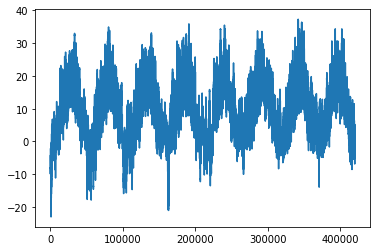

In [5]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

**Plotting the first 10 days of the temperature timeseries**

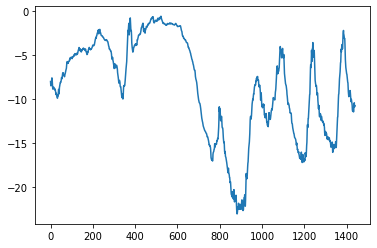

In [6]:
plt.plot(range(1440), temperature[:1440]) # first 10 day -> 24*6*10 

**Computing the number of samples we'll use for each data split**

In [7]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)
# validation set / test set -> more recent than the training data

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


### Preparing the data

**Normalizing the data**

In [8]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [9]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10) # generate array of intergers from 0-9
dummy_dataset = keras.utils.timeseries_dataset_from_array( # Creates a dataset of sliding windows over a timeseries provided as array.
    data=int_sequence[:-3], # the sequences we generate will be sampled from [0,1,2,3,4,5,6]
    targets=int_sequence[3:], # the target for the sequence that starts at data[N] will be data[N+3]
    sequence_length=3, # sequences will be 3 steps long
    batch_size=2, # the sequence will be batched in size 2
)

for inputs, targets in dummy_dataset: # dummydata의 모든 inputs , targets에 대해 
    for i in range(inputs.shape[0]): 
        print([int(x) for x in inputs[i]], int(targets[i])) # 모든 input[i]와 target[i]를 출력  

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


**Instantiating datasets for training, validation, and testing**

In [10]:
# training, validation, test set을 인스턴스화
sampling_rate = 6 # 시간당 하나의 지점에서 sampling
sequence_length = 120 # 관측치는 5일(120시간) 이전으로 돌아감
delay = sampling_rate * (sequence_length + 24 - 1) # 목표 : sequence 종료 후 24시간 후의 온도
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0, # 처음 50%를 사용
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

**Inspecting the output of one of our datasets**

In [11]:
# 각 데이터셋은 tuple(samples, targets)을 생성
# sample : 각각 120시간의 연속 입력 데이터를 포함하는 256개 샘플의 batch
# target : 256개의 target temperature의 배열
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


### A common-sense, non-machine-learning baseline

**Computing the common-sense baseline MAE**

In [12]:
# common - sense 접근 : 오늘의 기온이 어제의 기온과 같을 것이라고 예상하는 것
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


### Let's try a basic machine-learning model

**Training and evaluating a densely connected model**

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x) # 회귀 문제의 마지막 dense 계층에는 activation이 없음 
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"]) # 회귀 문제에서 주로 mse matric를 사용 
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 49s 56ms/step - loss: 11.4934 - mae: 2.6347 - val_loss: 10.5489 - val_mae: 2.5636
Epoch 2/10
792/819 [============================>.] - ETA: 1s - loss: 8.8211 - mae: 2.3377

**Plotting results**

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()
# tes mae 2.66 : common sense approach보다 성능 떨어짐

### Let's try a 1D convolutional model

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")
# tes mae 3.27 : common sense approach보다 성능 떨어짐

### A first recurrent baseline

**A simple LSTM-based model**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

## Understanding recurrent neural networks

densely connected networks and convnets -> has no memory  
seqence, temporal series를 처리하기 위해 전체 seqeunce를 한 번에 보여주어야 함  
ex)  densely connected model에서 5일간의 데이터를 flatten 한 것 -> feedforward networks  
이와는 대조적으로 우리는 문장을 읽을 때 눈으로 그 전 단어를 기억하면서 문장을 읽어나감. 과거의 정보를 구축하고 새로운 정보가 들어왔을 때 지속적으로 업데이트함 -> RNN의 원리!   
RNN -> 내부적으로 sequence elements를 loop

**NumPy implementation of a simple RNN**

In [ ]:
import numpy as np
timesteps = 100 # #of timesteps in the input sequence 
input_features = 32 # input feature space 
output_features = 64 # output feature space 
inputs = np.random.random((timesteps, input_features))
state_t = np.zeros((output_features,)) # initial state : all zero vector
W = np.random.random((output_features, input_features)) # creates random weight matrices
U = np.random.random((output_features, output_features)) 
b = np.random.random((output_features,))
successive_outputs = []
for input_t in inputs: # input_t is a vector of shape 
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b) # input + current state(previous output)
    successive_outputs.append(output_t) # store this output in a list
    state_t = output_t # update the state of the wetwork for the next timestep
final_output_sequence = np.stack(successive_outputs, axis=0) # final output is rank 2 tensor of shape

### A recurrent layer in Keras

**An RNN layer that can process sequences of any length**

In [ ]:
num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)

**An RNN layer that returns only its last output step**

In [ ]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=False)(inputs)
print(outputs.shape)

**An RNN layer that returns its full output sequence**

In [ ]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=True)(inputs)
print(outputs.shape)

**Stacking RNN layers**

In [ ]:
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)

실제로 simpleRNN은 거의 이용 X -> 너무 단순하기 때문  
LSTM : simpleRNN의 변형 -> 정보를 저장,처리중 오래된 신호가 점차 사라지는 것을 방지 

## Advanced use of recurrent neural networks

- recurrent dropout : dropout의 변형. overfitting의 방지
- stacking recurrent layer : representational power 증가
- bidirectional recurrent layer : 동일한 정보를 다른 방법으로 network에 제공, accuray 증가, forgeting issue 완화

### Using recurrent dropout to fight overfitting

**Training and evaluating a dropout-regularized LSTM**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x) # to regularization, add dropout layer ater the LSTM
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)

In [ ]:
inputs = keras.Input(shape=(sequence_length, num_features))
x = layers.LSTM(32, recurrent_dropout=0.2, unroll=True)(inputs)

### Stacking recurrent layers

**Training and evaluating a dropout-regularized, stacked GRU model**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs) # GRU -> LSTM과 유사
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

### Using bidirectional RNNs

**Training and evaluating a bidirectional LSTM**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset)

### Going even further

- dropout 비율 조정
- RMSprop의 learning rate를 조정하거나 다른 optimizer을 시도
- single dense layer 대신 stack of dense layer 사용
- 더 길거나 짧은 sequence, 다른 sampling rate, feature engineering

## Summary